<table><tr>
<td><img src="logo/Adagos_Logo.png" alt="Drawing" style="width: 150px;"/></td>
    <td><img src="logo/logo_sirea.png" alt="Drawing" style="width: 200px;"/></td>
</tr></table>


# Lecture des données

Choisir la station à étudier entre Marceau Almaric, SYD TGBT1, SYD TGBT2, SYD TGBT3


In [12]:
%matplotlib notebook
from tqdm.notebook import tqdm
from build_neureco import *
from sirea_storage import *
import datetime
import warnings
warnings.filterwarnings('ignore')

stat = widgets.Dropdown(
    options=['Marceau Almaric', 'SYD TGBT1', 'SYD TGBT2', 'SYD TGBT3'],
    value='Marceau Almaric',
    description='Station:')

cap = widgets.FloatSlider(value=50, min=0, max=100.0, step=10)
stat

Dropdown(description='Station:', options=('Marceau Almaric', 'SYD TGBT1', 'SYD TGBT2', 'SYD TGBT3'), value='Ma…

<IPython.core.display.Javascript object>


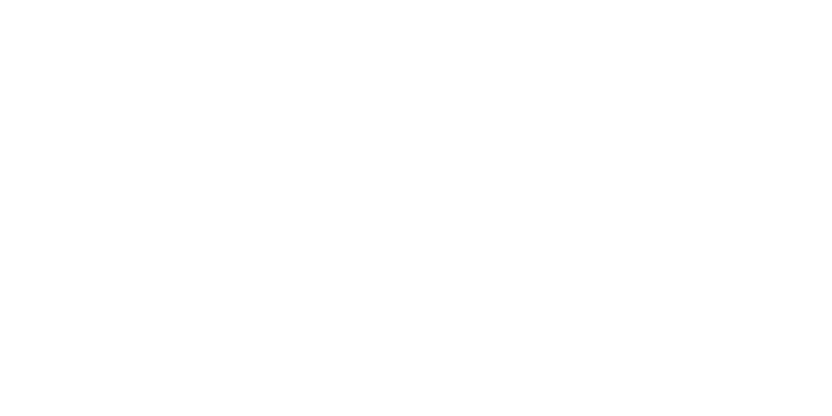

In [2]:
station = stat.value
d_read = data_reader(station, type='Sirea')
ax = d_read.full_data[['load_kW', 'prod_kW']].dropna().plot(figsize=(6, 3),
                                                            title=station,
                                                            color=[bleu, vert],
                                                            alpha=0.8)
plt.legend(['Consommation en kW', 'Production en kW'])
ax.set_ylabel("kW")

plt.tight_layout()
plt.show()

# Auto-consommation

Tout ce qui est produit par les panneaux solaires est soit consommé soit perdu. <br>
Et s'il n'y a pas assez de production, la consommation nécessaire restante est achetée à EDF. 

<IPython.core.display.Javascript object>


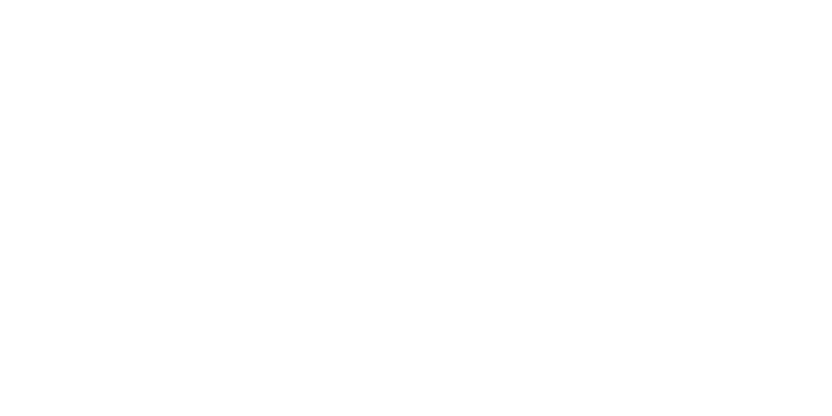

In [3]:
df = d_read.full_data
capacite = 0
no_storage = stockage(capacite, station)
no_storage.add_storage(d_read)
ax = no_storage.df[['import_kW', 'export_kW'
                 ]].dropna().plot(figsize=(6, 3),
                                  title='Autoconsommation sans batterie',
                                  color=['steelblue', 'lightcoral'],
                                  alpha=0.8)
plt.legend(['Achat à EDF en kW', 'Perte de production en kW'])
ax.set_ylabel("kW")

plt.tight_layout()
plt.show()

# Ajout batterie

Afin de diminuer les pertes de production, une batterie peut être installée. <br>
Les hypothèses sont les suivantes : <br>
- seuil max de charge = 98% de la capacite <br>
- seuil max de décharge = 20% de la capacite <br>
- puissance charge = puissance de l'armoire SIREA <br>
- puisance de décharge = 10% de la capacite <br>
                                                                               

In [4]:
HBox([Label('Capacité en kWh : '), cap])

<IPython.core.display.Javascript object>


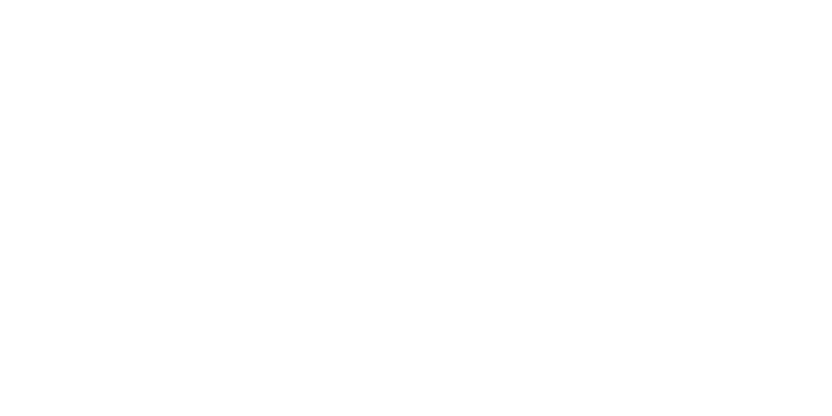

In [5]:
df = d_read.full_data
capacite = int(cap.value)
storage = stockage(capacite, station)
storage.add_storage(d_read)
ax = storage.df[['import_storage_kW', 'export_storage_kW']].dropna().plot(
    figsize=(6, 3),
    title='Autoconsommation avec batterie de ' + str(capacite) + ' kWh',
    color=['steelblue', 'lightcoral'],
    alpha=0.8)
plt.legend(['Achat à EDF en kW', 'Perte de production en kW'])
ax.set_ylabel("kW")

plt.tight_layout()
plt.show()

# Dimensionnement optimal de la batterie

Afin de déterminer le dimensionnement optimal de la batterie pour chaque site, nous allons comparer le pourcentage d'autoconsommation au temps d'amortissement. <br>
Les hypothèses sont les suivantes : <br>
- prix de la batterie = 120€ du kWh <br>
- prix achat EDF = 0.1€ du kWh pour Marceau Almaric, 0.15€ du kWh pour les autres stations <br>




In [6]:
df = d_read.full_data
capacities = [0, 10,20,30,40,50,60,70,80,90,100]
results = pd.DataFrame()
for c in capacities:
    stor = stockage(c, station)
    stor.add_storage(d_read)
    results = results.append(stor.interet_stockage(d_read))
results = results.set_index('capacite')
results


,%_autoconsomation,%_pertes_prod,gain_E_par_an,annees_amortissement
capacite,,,,
0,30.037474,35.879817,0.000000,NaN
10,31.061819,33.689850,196.516576,6.106355
20,31.974058,31.739247,371.525924,6.459845
30,32.796504,29.980363,529.308959,6.801321
40,33.564666,28.337384,676.677860,7.093479
50,34.259565,26.850833,809.991393,7.407486
60,34.875342,25.533219,928.125732,7.757570
70,35.407144,24.394903,1030.149854,8.154153
80,35.868301,23.407424,1118.621133,8.581994


<IPython.core.display.Javascript object>


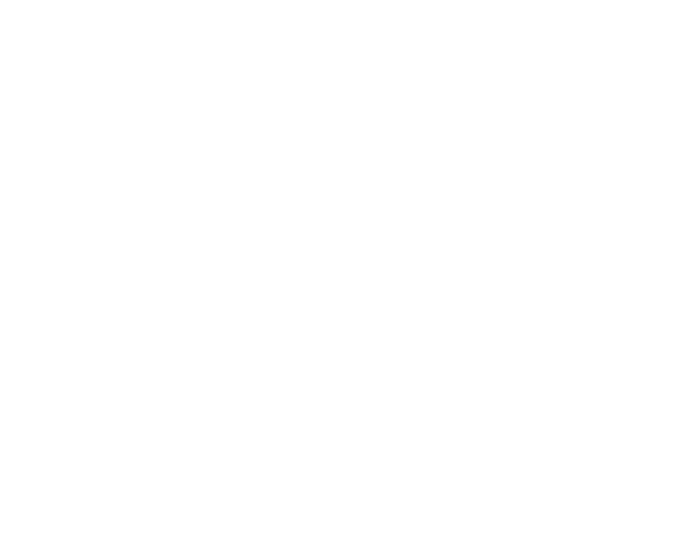

In [7]:
res = results.drop(results.index[0])

fig, ax1 = plt.subplots(figsize=(5, 4))
color = bleu
ax1.set_xlabel("nombre d'années d'amortissement")
ax1.set_ylabel("% d'autoconsommation", color=color)
ax1.plot(res.annees_amortissement,
         res['%_autoconsomation'],
         marker='.',
         color=bleu)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = vert
# we already handled the x-label with ax1
ax2.set_ylabel("% de pertes de production", color=color)
ax2.plot(res.annees_amortissement,
         res['%_pertes_prod'],
         marker='.',
         color=vert)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twiny()
ax3.set_xlim(ax1.get_xlim())
ax3.set_xticks(res.annees_amortissement)
ax3.set_xticklabels(res.index)
ax3.set_xlabel("capacité")
ax3.axvline(x=res.loc[60, 'annees_amortissement'],
            color='orange',
            linestyle='--')
plt.title(
    "Interêt de différentes batteries en fonction du temps d'amortissements")

plt.tight_layout()
plt.show()

# Optimisation de la consommation

Si l'on peut prévoir la consommation du lendemain, on peut choisir de décaler le surplus de consommation au moment où il y a un surplus de production 
<br> <br>
Simulons ce résultat pour un jour de semaine donné. On considérera que l'on ne peut pas décaler la consommation durant les week-ends

In [8]:
start_date = widgets.DatePicker(
    description='Jour : ',
    disabled=False, 
    min = storage.df.index.min(),
    value  = datetime.datetime(2020, 5, 1),
    max = storage.df.index.max()
)
start_date

DatePicker(value=datetime.datetime(2020, 5, 1, 0, 0), description='Jour : ')

<IPython.core.display.Javascript object>


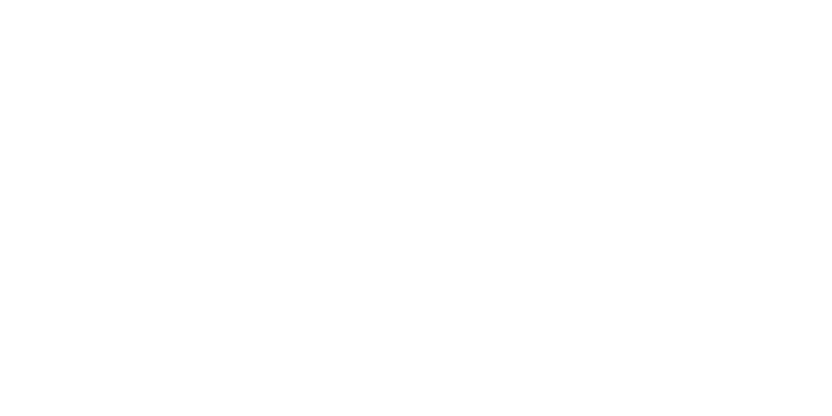

<IPython.core.display.Javascript object>


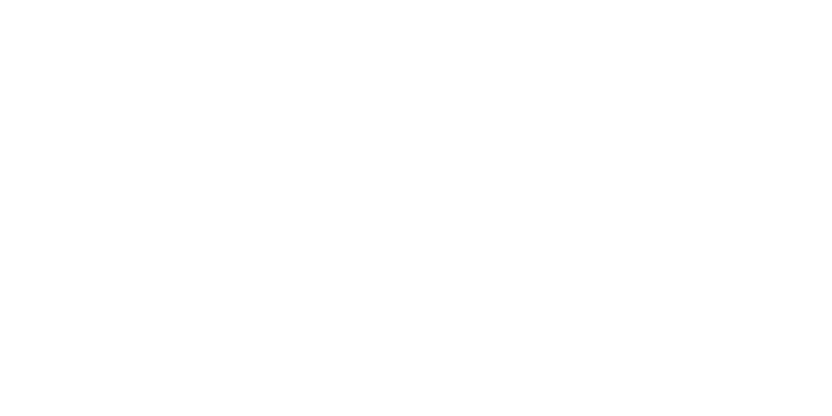

In [9]:
day = start_date.value.strftime("%Y-%m-%d")
opti = stockage(capacite, station)
opti.add_storage(d_read)
opti.shift_data(day);

cols = ['export_storage_kW', 'import_storage_kW']
i=0

for df in [storage.df, opti.df]:
    date_filter = df.index.strftime("%Y-%m-%d") == day
    title_name = 'Autoconsommation sans décalage'
    if i == 1:
        title_name = 'Autoconsommation avec décalage'
    x = df.loc[date_filter,cols].plot(figsize=(6, 3),
                                      title=title_name,
                                      color=['steelblue', 'lightcoral'],
                                      alpha=0.8)
    plt.legend(['Achat à EDF en kW', 'Perte de production en kW'])
    ax.set_ylabel("kW")
    i+=1


plt.tight_layout()
plt.show()

On réduit alors significativement les pertes de production et les achats d'électricité à EDF. Voyons dans ce cas, quelle est la capacité de batterie optimale.

## Batterie optimale avec optimisation

In [ ]:
capacities= [0, 10,20,30,40,50,60,70,80,90,100]
results = pd.DataFrame()
n = len(capacities)
m = len(opti.df.index.strftime("%Y-%m-%d").unique())
for c in tqdm(capacities, leave = False, position = 0):
    optim = stockage(c, station)
    optim.add_storage(d_read)
    ## shift load on every weekday
    for day in tqdm(optim.df.index.strftime("%Y-%m-%d").unique(), leave = False, position = 1):
        optim.shift_data(day)
    results = results.append(optim.interet_stockage(d_read))
results = results.set_index('capacite')
results
